<a href="https://colab.research.google.com/github/anirbansaha96/AI-ML-Playground/blob/master/llm_toxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets transformers evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 19.3 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from evaluate import load
from sklearn.metrics import mean_squared_error
import torch

if torch.cuda.is_available():
  print("GPU available! Using GPU for computations.")
  device = torch.device("cuda")
elif torch.backends.mps.is_available():
  print("Apple Metal available! Using Metal for computations.")
  device = torch.device("mps")
else:
  print("GPU not found. Using CPU.")
  device = torch.device("cpu")


GPU available! Using GPU for computations.


In [3]:

dataset = load_dataset("Arsive/toxicity_classification_jigsaw"
, split="train"
)
# textdetox/multilingual_toxicity_dataset
# google/jigsaw_toxicity_pred
# Arsive/toxicity_classification_jigsaw


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25960 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6490 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153164 [00:00<?, ? examples/s]

In [11]:
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score, accuracy_score
from transformers import pipeline

def evaluate_model(model_name, toxic_label, threshold=0.5):
    toxicity = load("toxicity", model_name, module_type="measurement")
    if torch.cuda.is_available():
      toxicity.toxic_classifier = pipeline("text-classification", model=model_name, top_k=99999, truncation=True, device=device)

    predictions = []
    ground_truth = []
    binary_predictions = []
    binary_ground_truth = []

    texts = dataset["comment_text"]
    labels = dataset["toxic"]
    predictions = toxicity.compute(predictions=texts, toxic_label=toxic_label)["toxicity"]

    binary_predictions = [1 if score >= threshold else 0 for score in predictions]
    binary_ground_truth = [1 if label >= threshold else 0 for label in labels]

    # Calculate classification metrics
    f1 = f1_score(binary_ground_truth, binary_predictions)
    precision = precision_score(binary_ground_truth, binary_predictions)
    recall = recall_score(binary_ground_truth, binary_predictions)
    accuracy = accuracy_score(binary_ground_truth, binary_predictions)


    return {
        "model_name": model_name,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy
    }



In [12]:
from time import time

In [13]:
model_results = {}
total_start = time()
models = [
    {"model_name": "facebook/roberta-hate-speech-dynabench-r4-target", "toxic_label": "hate"},
    {"model_name": "DaNLP/da-electra-hatespeech-detection", "toxic_label": "offensive"},
    {"model_name": "unitary/multilingual-toxic-xlm-roberta", "toxic_label": "toxic"},
    {"model_name": "unitary/toxic-bert", "toxic_label": "toxic"},
    {"model_name": "martin-ha/toxic-comment-model", "toxic_label": "toxic"},
    {"model_name": "textdetox/xlmr-large-toxicity-classifier", "toxic_label": "LABEL_1"},
    {"model_name": "s-nlp/roberta_toxicity_classifier", "toxic_label": "toxic"}
]

for model in models:
    try:
        model_start_time = time()
        metric_scores = evaluate_model(model_name=model["model_name"], toxic_label=model["toxic_label"])
        model_results[model["model_name"]] = metric_scores
        model_end_time = time()
        print(f"Model Time Taken - {model_end_time-model_start_time}")
    except Exception as e:
        print(f"Toxicity Calculation failed for {model['model_name']} with toxicity_label {model['toxic_label']} with error {e}")

total_end = time()

print(f"Total Time Taken - {total_end-total_start}")

Model Time Taken - 302.871830701828
Model Time Taken - 272.5929744243622


config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Model Time Taken - 349.64841628074646


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Model Time Taken - 306.69424629211426


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/403 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Model Time Taken - 177.0460262298584


config.json:   0%|          | 0.00/770 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Model Time Taken - 332.62840008735657


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Time Taken - 314.4271147251129
Total Time Taken - 2055.9115467071533


In [14]:
import json
print(json.dumps(model_results, indent=4))


{
    "facebook/roberta-hate-speech-dynabench-r4-target": {
        "model_name": "facebook/roberta-hate-speech-dynabench-r4-target",
        "f1_score": 0.6600370272414705,
        "precision": 0.9351019184652278,
        "recall": 0.5100138968364261,
        "accuracy": 0.7524268104776579
    },
    "DaNLP/da-electra-hatespeech-detection": {
        "model_name": "DaNLP/da-electra-hatespeech-detection",
        "f1_score": 0.5484503726951746,
        "precision": 0.872192513368984,
        "recall": 0.3999836507806752,
        "accuracy": 0.6896379044684129
    },
    "unitary/multilingual-toxic-xlm-roberta": {
        "model_name": "unitary/multilingual-toxic-xlm-roberta",
        "f1_score": 0.9072006160954948,
        "precision": 0.9517055655296229,
        "recall": 0.8666721164064416,
        "accuracy": 0.9164483821263483
    },
    "unitary/toxic-bert": {
        "model_name": "unitary/toxic-bert",
        "f1_score": 0.9385874706922792,
        "precision": 0.944610034773969

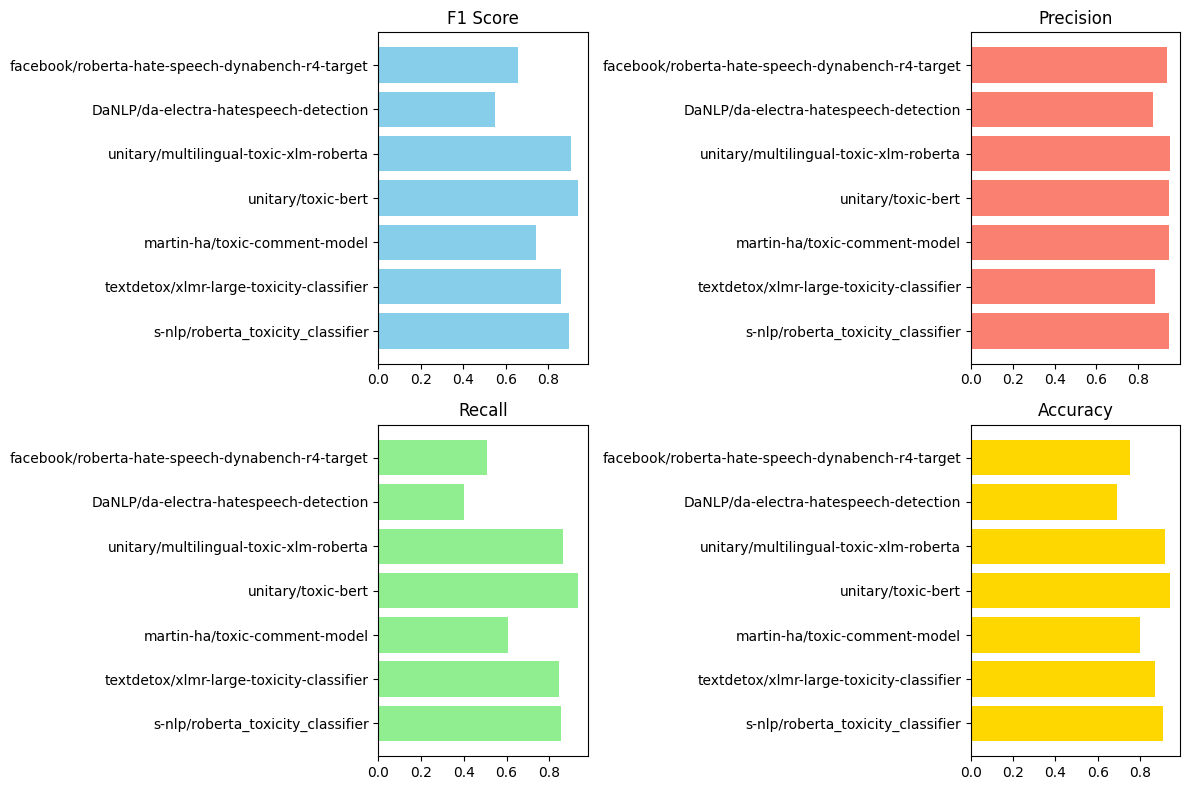

In [15]:
import matplotlib.pyplot as plt


# Extract model names and metric values
model_names = [model_results[model]["model_name"] for model in model_results]
f1_scores = [model_results[model]["f1_score"] for model in model_results]
precisions = [model_results[model]["precision"] for model in model_results]
recalls = [model_results[model]["recall"] for model in model_results]
accuracies = [model_results[model]["accuracy"] for model in model_results]

# Plotting
plt.figure(figsize=(12, 8))

# F1 Score Plot
plt.subplot(2, 2, 1)
plt.barh(model_names, f1_scores, color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.title('F1 Score')

# Precision Plot
plt.subplot(2, 2, 2)
plt.barh(model_names, precisions, color='salmon')
plt.gca().invert_yaxis()  # Invert y-axis
plt.title('Precision')

# Recall Plot
plt.subplot(2, 2, 3)
plt.barh(model_names, recalls, color='lightgreen')
plt.gca().invert_yaxis()  # Invert y-axis
plt.title('Recall')

# Accuracy Plot
plt.subplot(2, 2, 4)
plt.barh(model_names, accuracies, color='gold')
plt.gca().invert_yaxis()  # Invert y-axis
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# sorted_models = sorted(model_results.items(), key=lambda x: x[1])

# print("Model Performance (Best to Worst):")
# for model, score in sorted_models:
#   print(f"{model}: {score:.4f}")


In [ ]:
# from transformers import pipeline
# toxic_classifier = pipeline("text-classification", model="textdetox/xlmr-large-toxicity-classifier", top_k=99999, truncation=True)
# toxic_classifier.model.config.id2label